In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely import wkt

In [15]:
bike_set = pd.read_csv("Divvy_Trips_Chicago.csv", sep=",")
bike_set1 = bike_set.dropna()

# filter for birth years ≥1940 and make a copy before adding new columns
bike_set1 = bike_set1[bike_set1["BIRTH YEAR"] >= 1940].copy()

# compute age
bike_set1["AGE"] = (2019 - bike_set1["BIRTH YEAR"]).astype(int)

bike_clean = bike_set1.drop([
    'STOP TIME','FROM STATION NAME','TO STATION ID',
    'TO STATION NAME','TO LATITUDE','TO LONGITUDE','TO LOCATION','BIRTH YEAR'
], axis=1)

bike_clean.head()

,TRIP ID,START TIME,BIKE ID,TRIP DURATION,FROM STATION ID,USER TYPE,GENDER,FROM LATITUDE,FROM LONGITUDE,FROM LOCATION,AGE
0,22200000,04/03/2019 08:29:54 AM,5313,537,18,Subscriber,Male,41.883132,-87.637321,POINT (-87.637321 41.883132),37
1,22199999,04/03/2019 08:29:52 AM,5884,224,137,Subscriber,Male,41.862378,-87.651062,POINT (-87.651062 41.862378),54
2,22199998,04/03/2019 08:29:52 AM,4048,1085,210,Subscriber,Male,41.903450,-87.667747,POINT (-87.667747 41.90345),32
3,22199997,04/03/2019 08:29:50 AM,2638,309,96,Subscriber,Male,41.884616,-87.644571,POINT (-87.6445705849 41.88461618962),31
4,22199996,04/03/2019 08:29:45 AM,3179,501,77,Subscriber,Male,41.882242,-87.641066,POINT (-87.641066 41.882242),41


# Introduction to geographical data engineering 

We first start out by cleaning up the dataset in the steps stated in Milestone 1, differences are that we are keeping `From Longitude` and `From Latitude`, since it could be useful in our analysis of the geographical features

Next up we can see that Chicago is divided into **77 different community areas**, which is an useful way to subdivide our data into different regions, each with different characteristics that might prove interesting for our `Trip duration`. 

In [16]:
community_data = pd.read_csv("CommunityDataClean_2019.csv", sep=";")
community_data_clean = community_data.filter(['OBJECTID','GEOG', 'TOT_POP','TOT_ACRES', 'DROVE_AL', 'TRANSIT', 'WALK_BIKE',
                                              'NO_VEH', 'MEDINC', 'OWN_OCC_HU', 'RENT_OCC_HU', 'UNEMP', 'IN_LBFRC'], axis=1)
community_data_clean.head()

,OBJECTID,GEOG,TOT_POP,TOT_ACRES,DROVE_AL,TRANSIT,WALK_BIKE,NO_VEH,MEDINC,OWN_OCC_HU,RENT_OCC_HU,UNEMP,IN_LBFRC
0,14,Albany Park,51992,1229.160488,13090,8606,1548,3289,58128.20513,6738,9825,2060,29224
1,57,Archer Heights,13142,1283.804076,3638,988,262,613,46632.12435,2110,1784,605,6561
2,34,Armour Square,13455,637.424147,1984,1138,1265,2223,26466.21622,1927,3280,772,6620
3,70,Ashburn,43792,3109.741438,13110,2777,44,984,66560.12658,10946,2036,2904,22287
4,71,Auburn Gresham,46278,2411.968642,9475,4388,200,5216,31694.19134,7389,9722,4376,20714


**Source**: https://datahub.cmap.illinois.gov/maps/e22e50bf9e7547d3aa257edc4c466330/about 

The data above is provided by the Chicago Metropolitan Agency for Planning and can be found under CCA_2019
Based on the dataset, which provided detailed information on 231 different charateristics, the following charateristics has been chosen due to:

+ `GEOG`, `OBJECTID` : Name and ID of the community area, this is included in order to merge the dataset together and will be removed afterwards
+ `TOT_POP`, `TOT_ACRES`, : Total population will be divided by total area in order to find out the population density of a region, which could be a good indicator for increased bike usage.
+ `MEDINC`: Median income generally is an indicator for how wealthy and well established an area is, therefore this might point to an increase in alternative transportation availability, or it could lower the bike usage, since wealthier households will probably have multiple cars. Either way it will be useful for the analysis
+ `DROVE_AL`, `TRANSIT`, `WALK_BIKE`: All important indicators of the public transportation availability of an area, will be combined together to create a ratio of vehicles to total transportation usage 
+ `NO_VEH`: Could be an important indicator, since households with no cars must use alternative transportation methods, however this might be tightly correlated with the metric above, therefore it remains to be seen whether this will be included
+ `OWN_OCC_HU`, `RENT_OCC_HU`: Areas with more renters often have younger, more mobile populations who are more likely to use bike-sharing, while low-density, owner-heavy neighborhoods may result in fewer, longer rides. These two metrics will be combined together to create a ratio of Owner/Renter in an area 
+ `UNEMP`, `IN_LBFRC`: The ratio of unemployment can be deduced through dividing the amount of unemployed people through the total amount of the labor force. This could be a good indicator since an commuter-heavy areas might generate short, high-volume trips during rush hours

In [17]:
community_data_clean['POP_DENSITY'] = (community_data_clean['TOT_POP'] / community_data_clean['TOT_ACRES']).round(2) # people per acre
community_data_clean['VEH_RATIO'] = (community_data_clean['DROVE_AL'] / (community_data_clean['DROVE_AL'] + community_data_clean['TRANSIT'] + community_data_clean['WALK_BIKE'])).round(2)
community_data_clean['RENT_RATIO'] = (community_data_clean['RENT_OCC_HU'] / (community_data_clean['OWN_OCC_HU'] + community_data_clean['RENT_OCC_HU'])).round(2)
community_data_clean['UNEMP_RATIO'] = (community_data_clean['UNEMP'] / community_data_clean['IN_LBFRC']).round(2)


community_data_enhanced = community_data_clean.drop([
    'TOT_POP', 'TOT_ACRES', 'DROVE_AL', 'TRANSIT', 'WALK_BIKE',
    'OWN_OCC_HU', 'RENT_OCC_HU', 'UNEMP', 'IN_LBFRC'], axis=1)
community_data_enhanced['MEDINC'] = community_data_enhanced['MEDINC'].round(2) 
community_data_enhanced = community_data_enhanced.rename(columns={
    'GEOG': 'COMMUNITY',
    'MED_AGE': 'MEDIAN_AGE',
    'NO_VEH': 'NO_VEHICLES',
    'MEDINC': 'MEDIAN_INCOME',
    'POP_DENSITY': 'POPULATION_DENSITY',
    'VEH_RATIO': 'VEHICLE_RATIO',
    'RENT_RATIO': 'RENTAL_RATIO',
    'UNEMP_RATIO': 'UNEMPLOYMENT_RATIO'
})
community_data_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   OBJECTID            77 non-null     int64  
 1   COMMUNITY           77 non-null     object 
 2   NO_VEHICLES         77 non-null     int64  
 3   MEDIAN_INCOME       77 non-null     float64
 4   POPULATION_DENSITY  77 non-null     float64
 5   VEHICLE_RATIO       77 non-null     float64
 6   RENTAL_RATIO        77 non-null     float64
 7   UNEMPLOYMENT_RATIO  77 non-null     float64
dtypes: float64(5), int64(2), object(1)
memory usage: 4.9+ KB


In [18]:
boundaries = pd.read_csv("Boundaries_Community.csv", sep=",")
boundaries.drop(['AREA_NUM_1', 'SHAPE_AREA', 'SHAPE_LEN'], axis=1, inplace=True)
boundaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   the_geom    77 non-null     object
 1   AREA_NUMBE  77 non-null     int64 
 2   COMMUNITY   77 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.9+ KB


Source: https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-Map/cauq-8yn6

The data is provided by the City of Chicago and denotes the area boundaries of 77 different community areas as above, since the `AREA_NUMBE`from this dataset and `OBJECTID` from the previous dataset did not match up, some manual work had to be done in order to match up both. 

Since we are only interested in the boundaries of these areas, most of the other attributes were dropped, since they are not of relevancy to us. Afterwards, the 2 dataset will be combined.

In [19]:
boundaries_community = boundaries.merge(
    community_data_enhanced, 
    left_on='AREA_NUMBE', 
    right_on='OBJECTID', 
    how='inner')
boundaries_community.drop(['OBJECTID', 'AREA_NUMBE', 'COMMUNITY_x'], axis=1, inplace=True) # drop redundant columns
boundaries_community.rename(columns={'COMMUNITY_y': 'COMMUNITY'}, inplace=True)
boundaries_community.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   the_geom            77 non-null     object 
 1   COMMUNITY           77 non-null     object 
 2   NO_VEHICLES         77 non-null     int64  
 3   MEDIAN_INCOME       77 non-null     float64
 4   POPULATION_DENSITY  77 non-null     float64
 5   VEHICLE_RATIO       77 non-null     float64
 6   RENTAL_RATIO        77 non-null     float64
 7   UNEMPLOYMENT_RATIO  77 non-null     float64
dtypes: float64(5), int64(1), object(2)
memory usage: 4.9+ KB


Since we also want to match up each station with its corresponding area, we have to:

+ **Parse** each boundary’s polygon geometry from `the_geom` as well as the longitude and lattitude from each stations into proper GeoDataFrames with CRS ESRI:103270 (Code for Chicago)
+ **Spatially join** each point that lays within an area's polygon, so that it inherits the name of the `COMMUNITY`. We use an inner join in order to make sure that no information will be lost, even at the expense of missing some rows, since some stations' location might have lay outside our community boundaries 
+ **Merge** all per community metrics which we have defined before 
+ **Drop** redundant information

In [20]:
# Merge bike data with boundaries data
# 1) Parse the WKT polygons and set a GeoDataFrame
boundaries_community['geometry'] = boundaries_community['the_geom'].apply(wkt.loads)
boundaries_gdf = gpd.GeoDataFrame(boundaries_community,
                                  geometry='geometry',
                                  crs='ESRI:103270') # Chicago CRS

# 2) Turn bike_clean points into a GeoDataFrame
bike_clean['geometry'] = gpd.points_from_xy(
    bike_clean['FROM LONGITUDE'],
    bike_clean['FROM LATITUDE']
)
bike_gdf = gpd.GeoDataFrame(bike_clean,
                            geometry='geometry',
                            crs='ESRI:103270')

# 3) Spatial join: each point gets the COMMUNITY it falls within
bike_community = gpd.sjoin(
    bike_gdf,
    boundaries_gdf[['COMMUNITY','geometry']],
    how='inner'
)

bike_community = bike_community.merge(
    community_data_enhanced,
    on='COMMUNITY',
    how='inner'
)

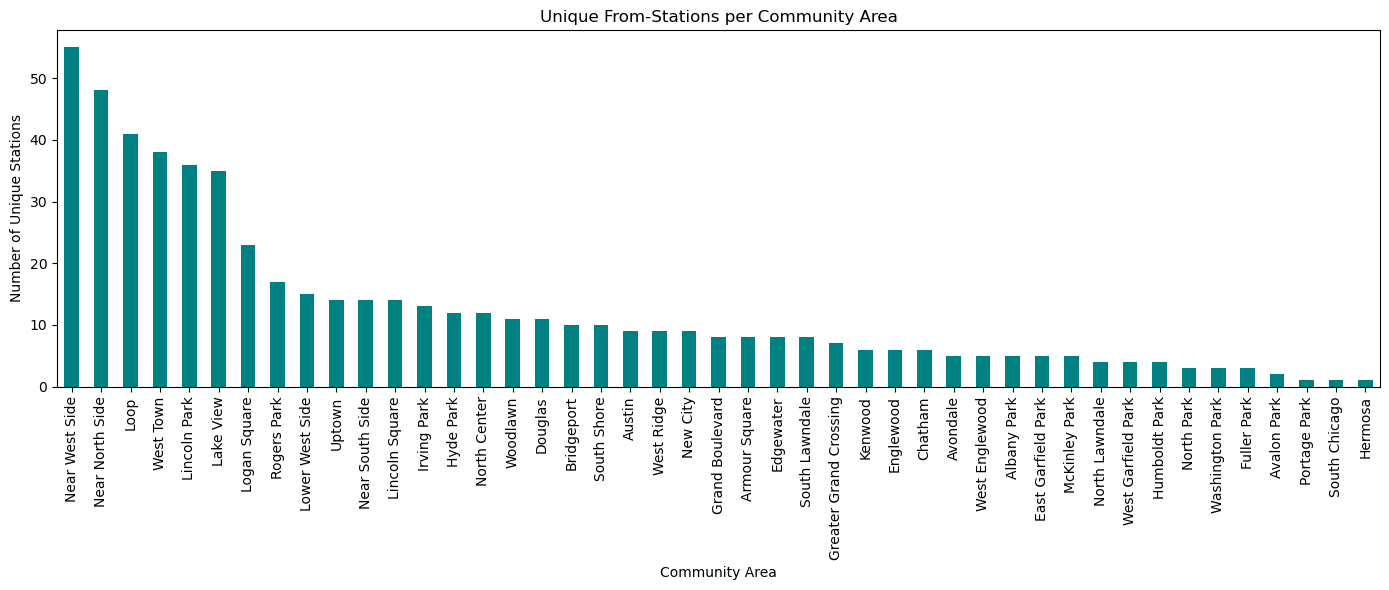

In [21]:
# 1) count unique 'FROM STATION ID' per COMMUNITY
station_counts = (
    bike_community
      .groupby('COMMUNITY')['FROM STATION ID']
      .nunique()
      .sort_values(ascending=False)
)

# 2) plot as bar chart
plt.figure(figsize=(14, 6))
station_counts.plot(
    kind='bar',
    color='teal'
)
plt.title('Unique From-Stations per Community Area')
plt.xlabel('Community Area')
plt.ylabel('Number of Unique Stations')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

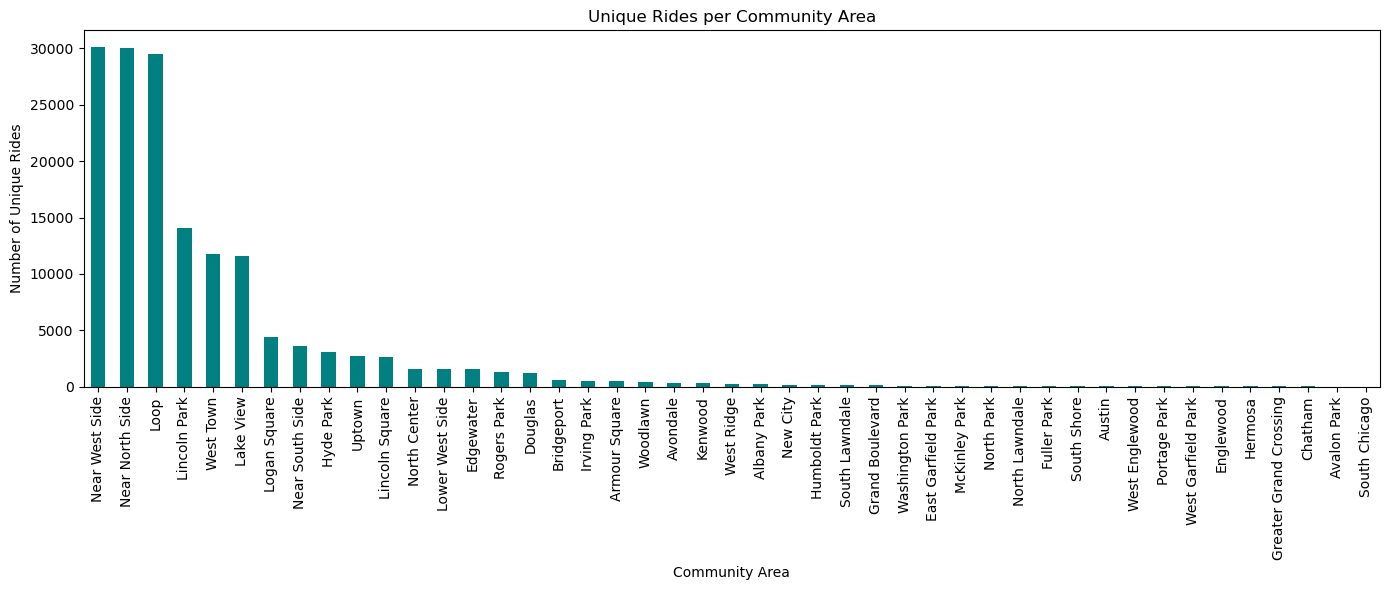

In [22]:
rides_counts = (
    bike_community
      .groupby('COMMUNITY')['TRIP ID']
      .nunique()
      .sort_values(ascending=False)
)

# 2) plot as bar chart
plt.figure(figsize=(14, 6))
rides_counts.plot(
    kind='bar',
    color='teal'
)
plt.title('Unique Rides per Community Area')
plt.xlabel('Community Area')
plt.ylabel('Number of Unique Rides')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

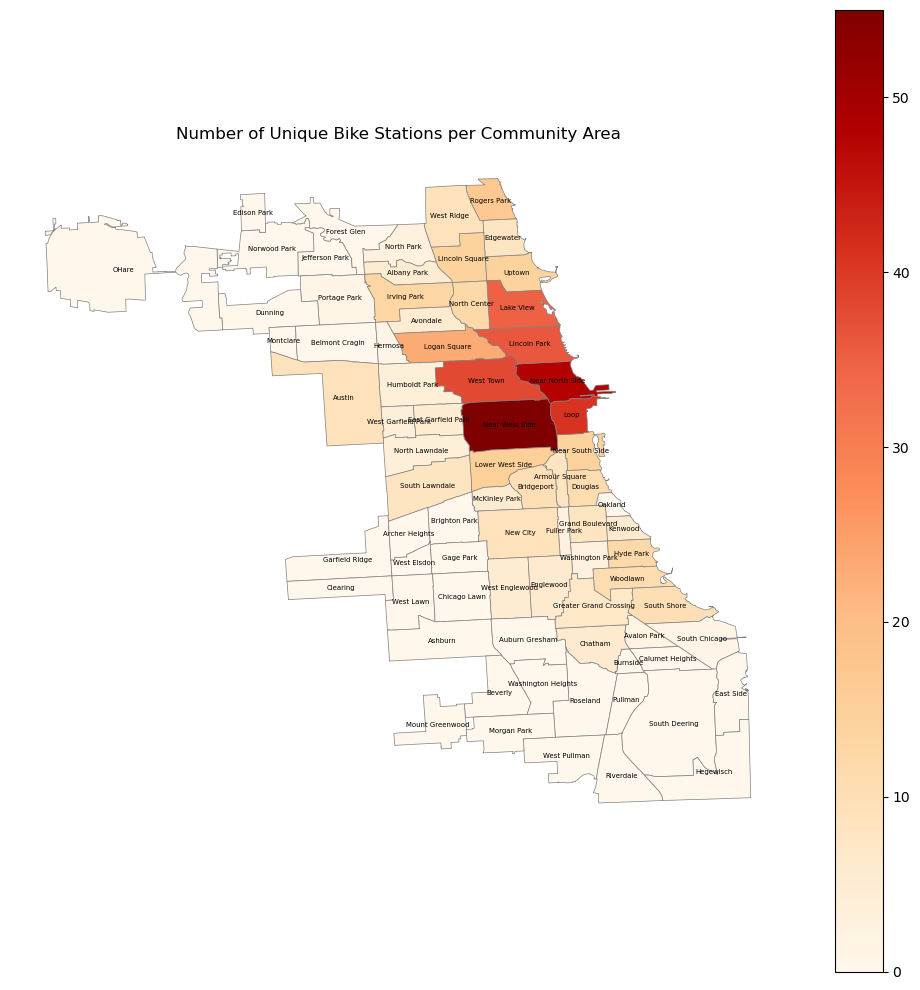

In [23]:
# project boundaries to Web-Mercator
boundaries_plot = boundaries_gdf.to_crs(epsg=3857)

# add station counts
boundaries_plot['station_counts'] = (
    boundaries_plot['COMMUNITY']
      .map(station_counts)
      .fillna(0)
      .astype(int)
)

# compute centroids for labeling
centroids = boundaries_plot.geometry.centroid
boundaries_plot['centroid_x'] = centroids.x
boundaries_plot['centroid_y'] = centroids.y

# plot choropleth
fig, ax = plt.subplots(figsize=(10, 10))
boundaries_plot.plot(
    column='station_counts',
    cmap='OrRd',
    linewidth=0.5,
    edgecolor='gray',
    legend=True,
    ax=ax
)

# add community labels
for _, row in boundaries_plot.iterrows():
    ax.text(
        row.centroid_x, 
        row.centroid_y, 
        row.COMMUNITY, 
        fontsize=5, 
        ha='center',
        va='center'
    )

ax.set_axis_off()
plt.title('Number of Unique Bike Stations per Community Area')
plt.tight_layout()
plt.show()


# Remarks about the distribution of Divvy stations 

As we can see from the map and the chart above, the amount of Divvy stations and therefore starting locations of each bikes belong overwhelmingly to 6 communities, which could prove problematic to our data, since the variance of various metrics as described above might be too low to yield any meaningful understanding. Therefore it is an open question whether or not the inclusion of such geographical data will prove useful for us. Two possible solutions:

+ Underweight samples from overrepresented regions, this could however prove problematic since the vast majority of our data/bike rides start from these regions
+ Find more sample for underrepresented regions, however this could be difficult, since the latest data are from 2019 in the provided dataset and further network expansion will not be present

In [24]:
bike_community.drop(['index_right', 'FROM LATITUDE', 'FROM LONGITUDE', 'geometry',
                    'FROM LOCATION', 'COMMUNITY'], axis=1, inplace=True)
bike_community.rename(columns={'OBJECTID': 'COMMUNITY_ID'}, inplace=True)


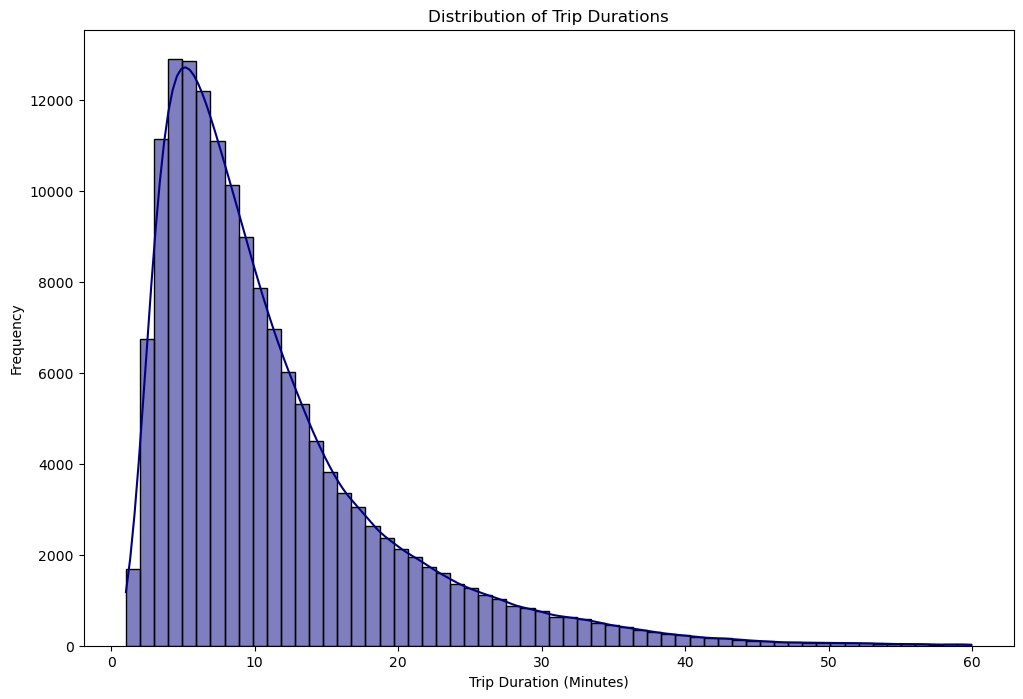

count    154171.000000
mean         11.138831
std           8.233318
min           1.016667
25%           5.400000
50%           8.700000
75%          14.166667
max          59.950000
Name: TRIP DURATION, dtype: float64

In [25]:
# Plot the distribution of trip durations
Trip_Duration = bike_community['TRIP DURATION'].dropna()/ 60  # Convert to minutes
Trip_Duration = Trip_Duration[Trip_Duration < 60]  # Filter outliers over 60 minutes
plt.figure(figsize=(12, 8))
sns.histplot(
    Trip_Duration,
    bins=60,
    kde=True,
    color='navy'
)
plt.title('Distribution of Trip Durations')
plt.xlabel('Trip Duration (Minutes)')
plt.ylabel('Frequency')
plt.show()
Trip_Duration.describe()

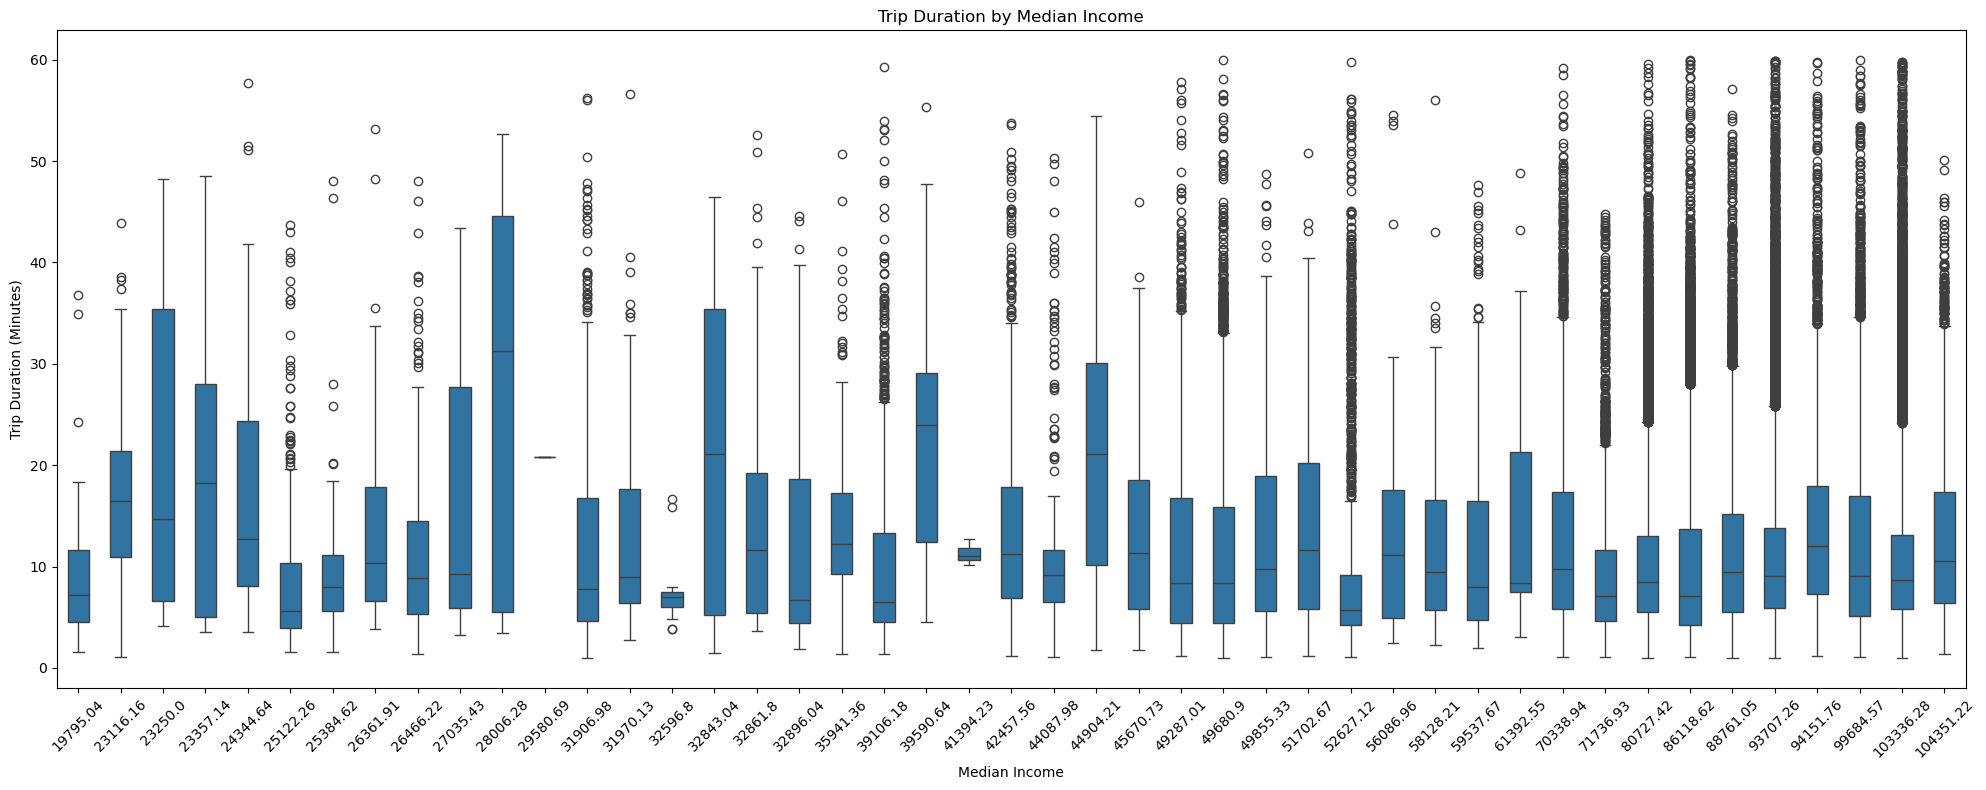

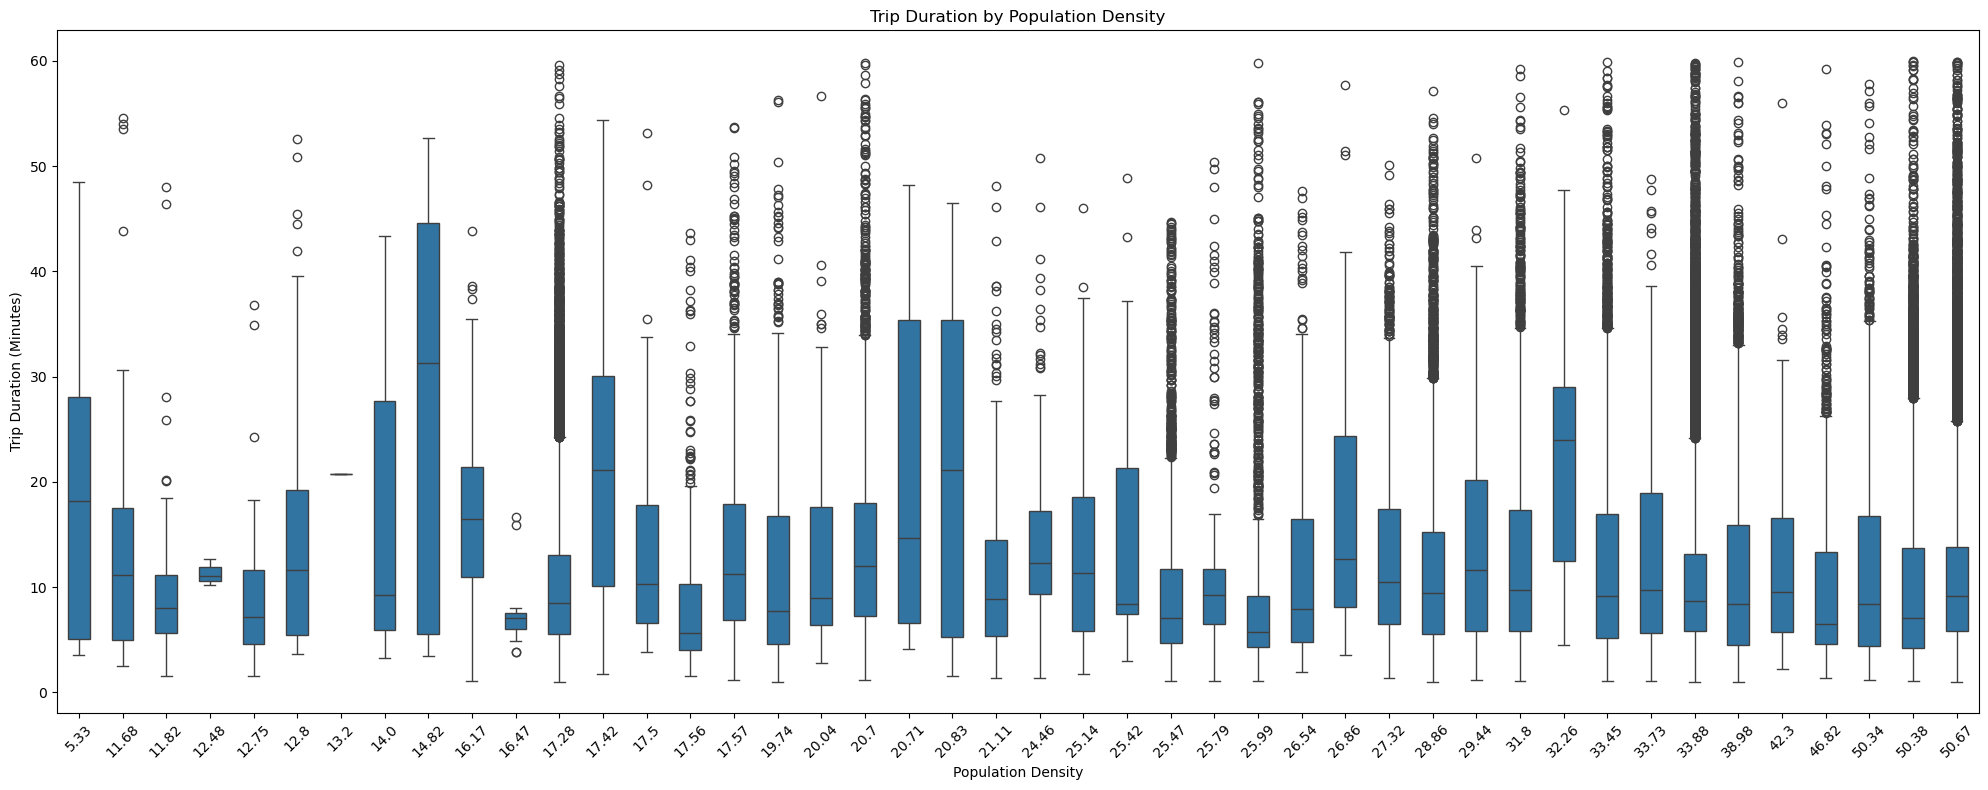

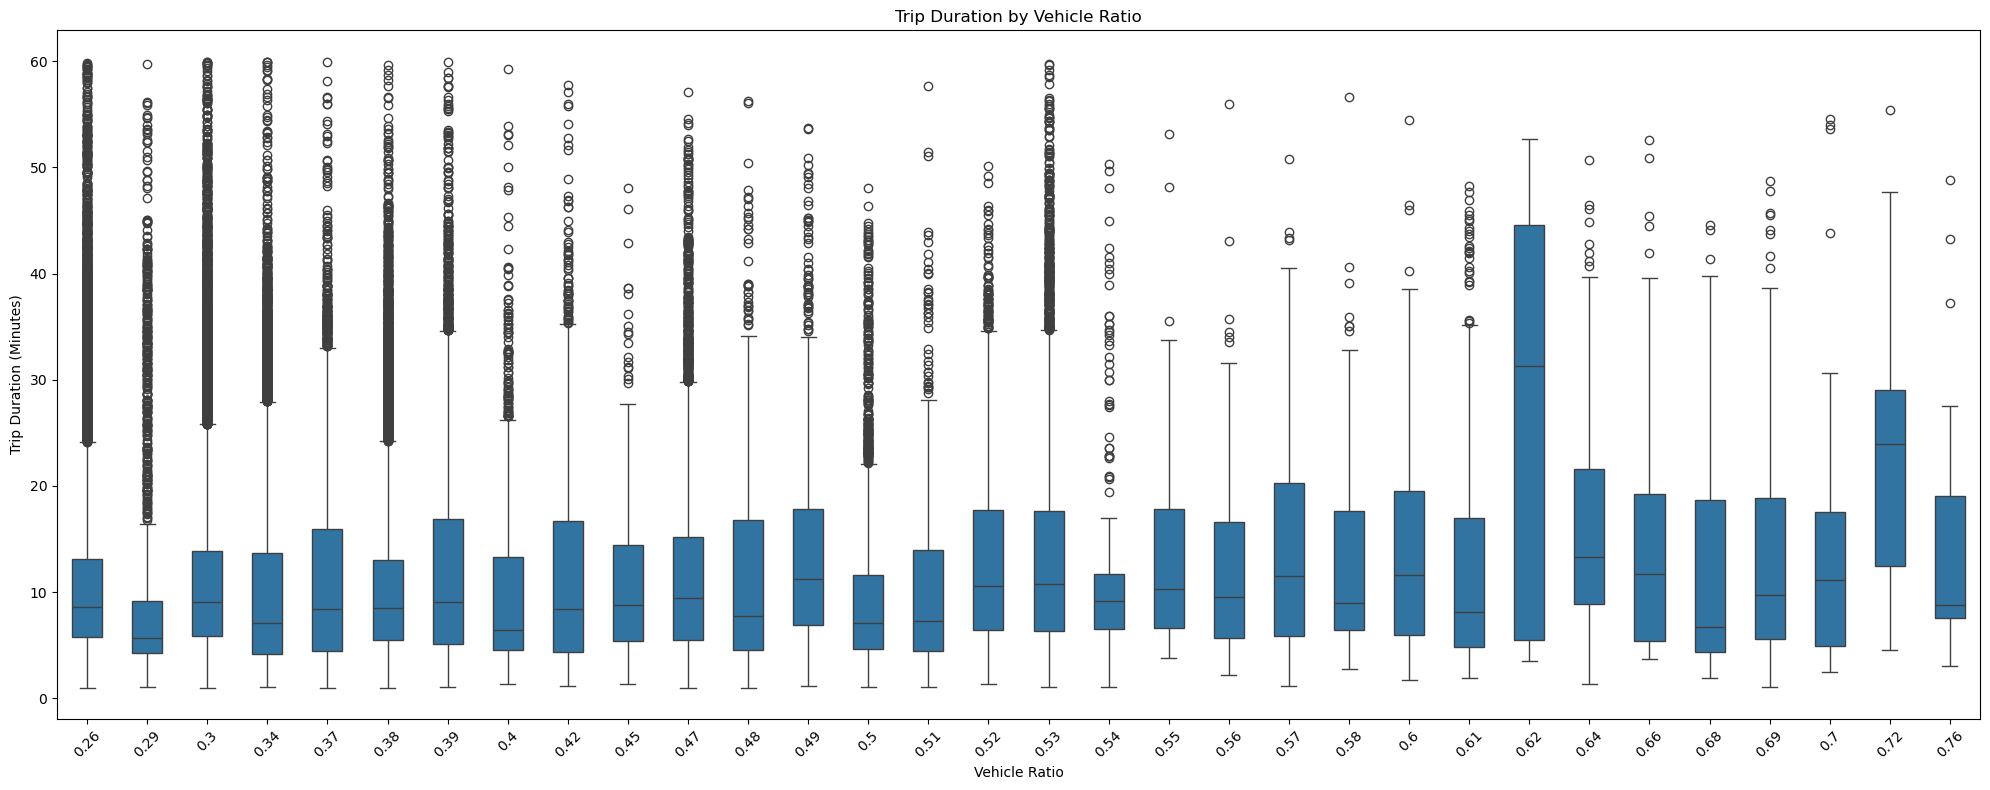

In [26]:
# Plot trip distribution by median income, population density, and vehicle ratio
def plot_trip_distribution_by_feature(feature, title):
    plt.figure(figsize=(20, 8))
    sns.boxplot(
        x=feature,
        y=Trip_Duration,
        data=bike_community,
        width=0.5,
    )
    plt.title(title)
    plt.xlabel(feature.replace('_', ' ').title())
    plt.ylabel('Trip Duration (Minutes)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_trip_distribution_by_feature('MEDIAN_INCOME', 'Trip Duration by Median Income')
plot_trip_distribution_by_feature('POPULATION_DENSITY', 'Trip Duration by Population Density')
plot_trip_distribution_by_feature('VEHICLE_RATIO', 'Trip Duration by Vehicle Ratio')